In [1]:
from copy import deepcopy

from default import TARGET_ANCHOR_VP, TARGET_PROBE_VP, TARGET_ALL_VP, FIGURE_PATH, ANCHORS_FILE, PROBES_FILE, REMOVED_PROBES_FILE
from utils.measurement_utils import load_json, dump_json
from utils.atlas_api import get_measurements_from_tag

## load results

In [2]:
# time and memory consuming operation

# to get the original result
uuids = ["8ac19a02-d964-4aef-b233-d272d0d08669", "9b2dcfb5-1fde-4b95-810b-ada4d1277d48"]

# to get your own result
#uuids = ["insert tag"]


measurement_results = {}
for uuid in uuids:
    measurement_result = get_measurements_from_tag(uuid)
    measurement_results.update(measurement_result)

dump_json(measurement_results, TARGET_PROBE_VP)

number of targets measurements: 2


In [3]:
print(len(measurement_result))

for i, (target_addr, results) in enumerate(measurement_results.items()):
    if i > 20 : break
    print(target_addr, len(results))

2
212.101.201.29 4
212.10.11.213 4


## Parse results

In [4]:
anchors = load_json(ANCHORS_FILE)

probes = load_json(PROBES_FILE)

removed_probes = load_json(REMOVED_PROBES_FILE)

In [5]:
measurement_results = load_json(TARGET_PROBE_VP)

In [6]:
anchors_dict = {}
for anchor in anchors:
    anchors_dict[anchor["address_v4"]] = anchor

probes_dict = {}
for probe in probes:
    probes_dict[probe["address_v4"]] = probe

In [8]:
# check, for each target that they belong to target dataset, do the same for vps
iterator = deepcopy(measurement_results)
for i, target in enumerate(iterator):

    # check that target in target dataset
    try:
        target_description = anchors_dict[target]
    except KeyError:
        print("target error")
        measurement_results.pop(target)
        continue

    # check if target in removed probes
    if target in removed_probes:
        measurement_results.pop(target)
        continue

    # check that all vps are in vps dataset
    tmp_vps = deepcopy(measurement_results[target])
    for vp in tmp_vps:
        # check that target in target dataset
        try:
            vp_description = probes_dict[vp]
        except KeyError:
            measurement_results[target].pop(vp)
            continue

        # check if vp in removed probes
        if vp in removed_probes:

            measurement_results[target].pop(vp)
            continue

        # remove target from vps
        if vp == target:
            measurement_results[target].pop(vp)
            continue

print("nb target measurements after filtering:", len(measurement_results))

# save results
dump_json(measurement_results, TARGET_PROBE_VP)

nb target measurements after filtering: 2


## Merge anchor and probe measurements

In [2]:
anchor_measurement_results = load_json(TARGET_ANCHOR_VP)

probe_measurement_results = load_json(TARGET_PROBE_VP)

print("anchor measurement results len: ", len(anchor_measurement_results))
print("probe measurement results len: ", len(probe_measurement_results))

anchor measurement results len:  2
probe measurement results len:  2


In [3]:
iterator = deepcopy(anchor_measurement_results)
for i, element in enumerate(iterator):
    try:
        measurement = probe_measurement_results[element]
        anchor_measurement_results[element].update(measurement)
    except KeyError:
        anchor_measurement_results.pop(element)

print(len(anchor_measurement_results))

0


In [4]:
iterator = deepcopy(probe_measurement_results)
for i, element in enumerate(iterator):
    try:
        measurement = anchor_measurement_results[element]
        probe_measurement_results[element].update(measurement)
    except KeyError:
        probe_measurement_results.pop(element)

print(len(probe_measurement_results))

0


In [5]:
# save results
dump_json(probe_measurement_results, TARGET_ALL_VP)

# Plot results

In [1]:
import pickle
import logging
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 

from collections import OrderedDict
from copy import deepcopy

from geoloc_imc_2023.default import DATA_PATH, FIGURE_PATH
from geoloc_imc_2023.measurement_utils import load_atlas_anchors, load_atlas_probes

NB_TRIAL = 100

font = {#'family' : 'normal',
    'weight' : 'bold',
    'size'   : 16
}
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fontsize_axis = 17
font_size_alone = 14

matplotlib.rc('font', **font)

logger = logging.getLogger()

def ecdf(data, array: bool=True):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    if not array:
        return pd.DataFrame({'x': x, 'y': y})
    else:
        return x, y


In [2]:
result_path = DATA_PATH / "anchor_target_probe_vp_data.pickle"

with open(result_path, "rb") as f:
    figure_results = pickle.load(f)

In [ ]:
for result in figure_results:
    print(result['subset_size'])
    

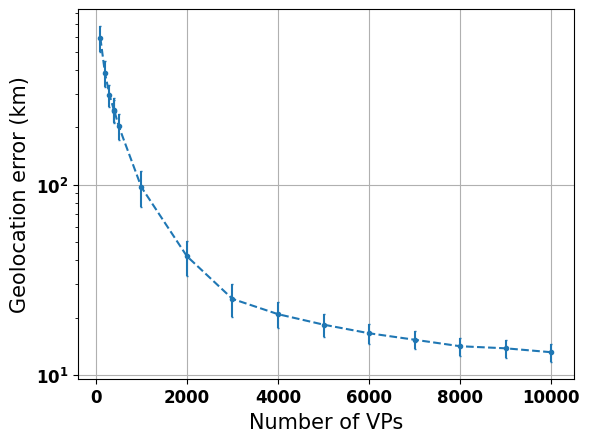

In [18]:
x = np.array([result['subset_size'] for result in figure_results])
y = np.array(
    [
        result["cbg"]["median_error"]
        for result in figure_results
    ]
)
e = np.array(
    [
        result["cbg"]["deviation"]
        for result in figure_results
    ]
)
plt.errorbar(x, y, e, marker=".", capsize=1, linestyle="--")

plt.xlabel("Number of VPs", fontsize=15)
plt.ylabel("Geolocation error (km)", fontsize=15)
plt.tick_params(labelsize=12)
plt.yscale("log")
plt.grid()
plt.savefig(FIGURE_PATH / "cbg/figure_3_a_anchor_target_probe_vp_cbg.png")
plt.savefig(FIGURE_PATH / "cbg/figure_3_a_anchor_target_probe_vp_cbg.pdf")
plt.show()

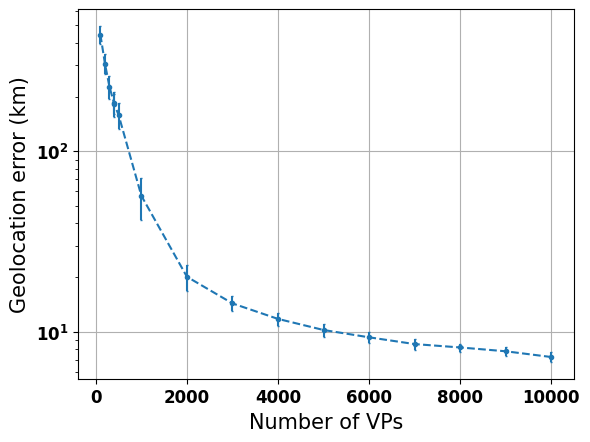

In [7]:
x = np.array([result['subset_size'] for result in figure_results])
y = np.array(
    [
        result["shortest_ping"]["median_error"]
        for result in figure_results
    ]
)
e = np.array(
    [
        result["shortest_ping"]["deviation"]
        for result in figure_results
    ]
)
plt.errorbar(x, y, e, marker=".", capsize=1, linestyle="--")
plt.xlabel("Number of VPs", fontsize=15)
plt.ylabel("Geolocation error (km)", fontsize=15)
plt.yscale("log")
plt.tick_params(labelsize=12)
plt.grid()
plt.savefig(
    FIGURE_PATH / "shortest_ping/figure_3_a_anchor_target_probe_vp_shortest_ping.png"
)
plt.savefig(
    FIGURE_PATH / "shortest_ping/figure_3_a_anchor_target_probe_vp_shortest_ping.pdf"
)
plt.show()

In [12]:
for s in figure_results:
    print(s['subset_size'])

10
100
200
300
400
400
500
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


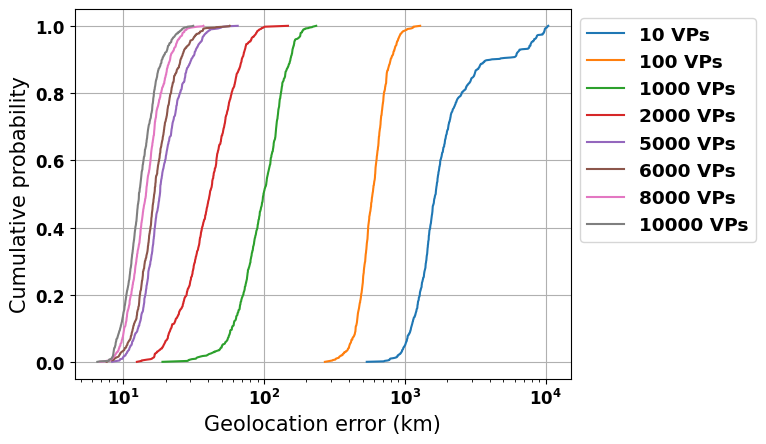

In [14]:
fig, ax = plt.subplots()

for vp_set_size in [10,100, 1000, 2000, 5000, 6000, 8000, 10000]:
    subset_results = []

    index = None
    for index, results in enumerate(figure_results):
        if results['subset_size'] == vp_set_size:
            break

    vp_subset_results = figure_results[index]["cbg"]["data"]

    for i in range(0, len(vp_subset_results), NB_TRIAL):
        subset_results.append(np.median(vp_subset_results[i : i + NB_TRIAL]))

    x, y = ecdf(subset_results)
    ax.plot(x, y, label=f"{vp_set_size} VPs")

legend = ax.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize = "small")
legend.get_frame()

plt.xlabel("Geolocation error (km)", fontsize=15)
plt.ylabel("Cumulative probability", fontsize=15)
plt.tick_params(labelsize=12)
plt.xscale("log")
plt.grid()
plt.savefig(FIGURE_PATH / "cbg/figure_3_b_anchor_target_probe_vp_cbg.png", bbox_inches='tight')
plt.savefig(FIGURE_PATH / "cbg/figure_3_b_anchor_target_probe_vp_cbg.pdf", bbox_inches='tight')
plt.show()

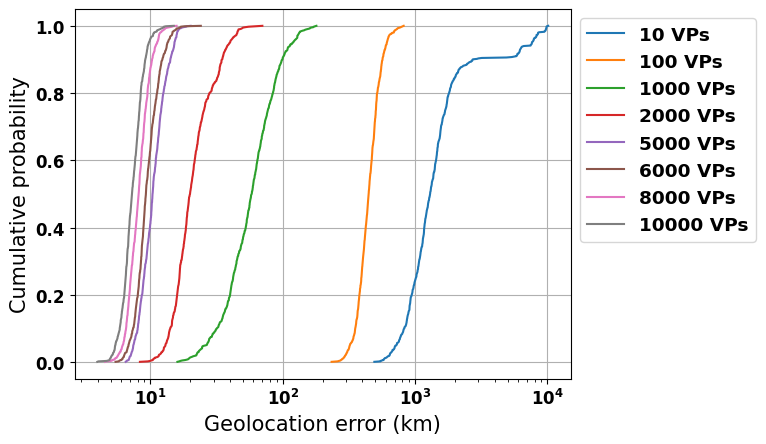

In [16]:
fig, ax = plt.subplots()

for vp_set_size in [10,100, 1000, 2000, 5000, 6000, 8000, 10000]:
    subset_results = []

    index = None
    for index, results in enumerate(figure_results):
        if results['subset_size'] == vp_set_size:
            break

    vp_subset_results = figure_results[index]["shortest_ping"]["data"]

    for i in range(0, len(vp_subset_results), NB_TRIAL):
        subset_results.append(np.median(vp_subset_results[i : i + NB_TRIAL]))

    x, y = ecdf(subset_results)
    ax.plot(x, y, label=f"{vp_set_size} VPs")

legend = ax.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize = "small")
legend.get_frame()

plt.xscale("log")
plt.grid()
plt.xlabel("Geolocation error (km)", fontsize=15)
plt.ylabel("Cumulative probability", fontsize=15)
plt.tick_params(labelsize=12)
plt.savefig(FIGURE_PATH / "shortest_ping/figure_3_b_anchor_target_probe_vp_shortest_ping.png", bbox_inches='tight')
plt.savefig(FIGURE_PATH / "shortest_ping/figure_3_b_anchor_target_probe_vp_shortest_ping.pdf", bbox_inches='tight')
plt.show()

## MULTIPROCESSING

In [17]:
out_file = DATA_PATH / "anchor_target_probe_vp_data.pickle"

with open(out_file, "rb") as f: 
    resutls = pickle.load(f)

In [21]:
subsets = [5, 10, 15]
args = [[measurement_results, target_dataset, vp_dataset, subset] for subset in subsets]

for arg in args:
    _,_,_, subset_size = arg
    print(subset_size)

5
10
15


In [30]:
subsets = [5, 10, 15]
for subset in subsets:
    print(subset)

5
10
15


In [31]:

with multiprocessing.Pool(4) as pool:
    # create a set of word hashes
    known_words = pool.starmap(get_vps_subset_results, [[measurement_results, target_dataset, vp_dataset, subset] for subset in subsets])

INFO:root:vp subset size: 5
INFO:root:subset size: 5 done.
INFO:root:median cbg = 1581.7164950558774 | std cbg = 34.378899426633325
INFO:root:median shortest_ping = 1212.920133558501 | std shortest_ping = 92.04241400348451
INFO:root:results saved
INFO:root:vp subset size: 10
INFO:root:subset size: 10 done.
INFO:root:median cbg = 963.1755955206245 | std cbg = 29.774451700224517
INFO:root:median shortest_ping = 834.7169654405586 | std shortest_ping = 64.95890725935152
INFO:root:results saved
INFO:root:vp subset size: 15
INFO:root:subset size: 15 done.
INFO:root:median cbg = 1035.4800147293142 | std cbg = 65.1777732085061
INFO:root:median shortest_ping = 634.345486440734 | std shortest_ping = 2.839479172445806
INFO:root:results saved


In [28]:
with open(DATA_PATH / "test_multipath.pickle", "rb") as f:
    cached_results = pickle.load(f)

for subset_results in cached_results:
    print(subset_results['subset_size'])

1
2
3


In [24]:
from multiprocessing import Pool

def myfunc(a, b, c):
    logger.info(f"{a}, {b}, {c}")

df_A = 1
df_B = 2

subsets = [1,2, 3]
def main():
    with Pool() as pool:
        pool.starmap(myfunc,[[df_A, df_B, x] for x in subsets])

if __name__ == '__main__':
    main()

INFO:root:1, 2, 1
INFO:root:1, 2, 3
INFO:root:1, 2, 2
